<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (a)

## Simple Moving Averages

本章用SMA介绍算法交易策略的向量化事后检验，基础是第8章的技术分析示例

### Data Import

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [5]:
symbol = 'AAPL.O'

In [6]:
data = (
    pd.DataFrame(raw[symbol])
    .dropna()
)

### Trading Strategy

In [7]:
# 短期SMA值
SMA1 = 42  
# 长期SMA值
SMA2 = 252  

In [8]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()  
data['SMA2'] = data[symbol].rolling(SMA2).mean()  

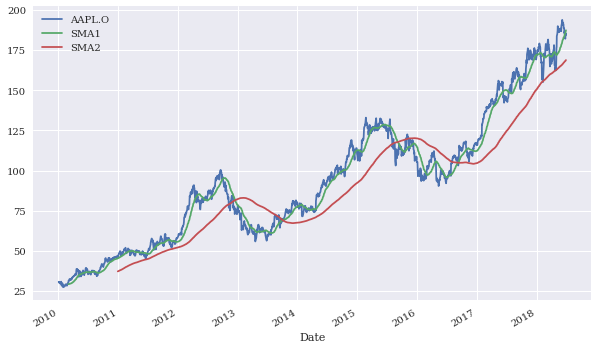

In [9]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_01.png')

In [10]:
data.dropna(inplace=True)

In [11]:
# 短期SMA在长期SMA之上时买入（=+1）
# 短期SMA在长期SMA之下时卖出（=−1）
# np.where(cond, a, b)逐个元素地计算条件cond，如果为True则设值a，否则设值b
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1) 

In [12]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


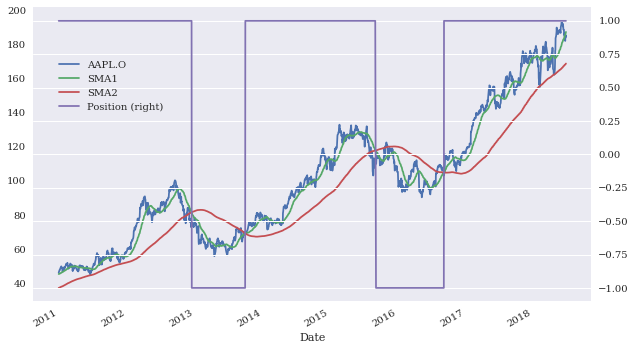

In [13]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_02.png')

### Vectorized Backtesting

向量化事后检验

现在，向量化事后检验可以按照以下方式实施。首先计算对数收益率。然后将头寸（以+1或者−1表示）乘以对应的对数回报率。这种简单的计算是可能的，因为多头头寸赚取的是苹果股票的正收益，而空头头寸赚取的是苹果股票的负收益。最终，将苹果公司股票的对数收益率与基于SMA的算法交易策略加总，并对其应用指数函数以得出绩效

In [14]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [15]:
# 将头寸值（移位一天）乘以苹果公司的对数收益率；移位是避免后见偏差所必需的
data['Strategy'] = data['Position'].shift(1) * data['Returns']  

In [16]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [17]:
data.dropna(inplace=True)

In [19]:
# 加总策略的对数回报率和基准投资，计算其指数值以得出绝对绩效
np.exp(data[['Returns', 'Strategy']].sum())  

Returns     4.017148
Strategy    5.811299
dtype: float64

In [20]:
# 计算策略与基准投资的年化波动率
data[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.250571
Strategy    0.250407
dtype: float64

这些数字说明，算法交易策略确实胜过被动持有苹果股票的基准投资。由于策略的类型和特性以及年化波动率相同，所以策略本身也胜过风险调整基础上的基准投资

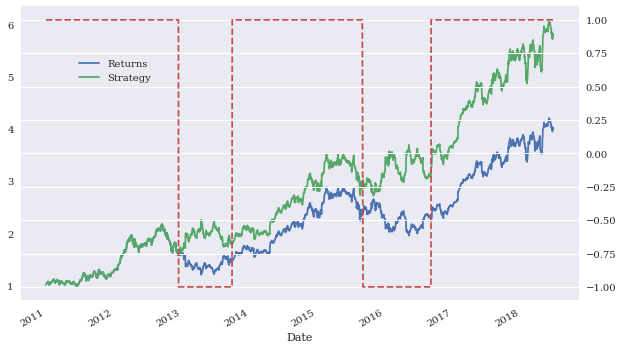

In [21]:
ax = data[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_03.png');

### Optimization

人们自然会问，选择参数SMA1=42和SMA2=252是否“正确”。一般来说，投资者希望在其他条件相同的情况下得到更高的收益。因此，他们可能倾向于寻找最大化对应时期内收益的参数。为此，可以使用暴力方法，对不同参数组合并重复整个向量化事后检验过程，记录结果，然后进行排名。下面的代码就用于实现这个功能

In [22]:
from itertools import product

In [23]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

In [24]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  # 组合所有SMA1和SMA2值
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = results.append(pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'OUT': perf['Strategy'] - perf['Returns']},
                 index=[0]), ignore_index=True)  

In [25]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [26]:
# 下面的代码给出结果的概要，并显示事后检验中绩效最佳的 7个参数组合。排名的根据是算法交易策略绩效与基准投资相比胜出的比例。由于 SMA2 参数的选择影响时间间隔长度和实施向量化事后检验的数据集，因此基准投资的绩效也各不相同
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


一般来说，算法交易策略背景下任何类型的优化、拟合或者训练都很容易导致过度拟合。这意味着，选择的参数可能对于使用的数据集表现（异常）良好，但在其他数据集或者实践中却表现（异常）糟糕。

## Random Walk Hypothesis

虽然本质上很清楚，但这些结果与随机游走假设（RWH）的预测相反。根据这种假设，此类预测性方法完全不应该得到任何效益上的增长。RWH假设金融市场中的价格遵循随机游走模式，或者在连续的时间里呈无漂移的算术布朗运动。未来任何时间点，无漂移算术布朗运动的预期值等于今天的值。因此，从最小二乘法的意义上，如果RWH成立，对明日价格的最佳预测就是今日的价格。

RWH与有效市场假设（EMH）一致，用非技术性的话说，后者假设市场价格反映了“所有可用信息”。通常要区分不同的市场有效度，如“弱”“半强”和“强”，可以更加明确地定义“所有可用信息”的涵盖范围。从形式上说，这样的定义可以基于理论上的信息集概念和用于编程目的的数据集，正如下面的引语所述：

如果根据信息集 S 交易无法得到经济利益，那么市场对该信息集来说就是有效的。

——Michael Jensen (1978)

进行证明预测第二天的股价最好的参考就是今天的股价，RWH

In [34]:
symbol = '.SPX'

In [35]:
data = pd.DataFrame(raw[symbol])
data.dropna(inplace=True)

In [36]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data[col] = data[symbol].shift(lag)  
    cols.append(col)  
    data.dropna(inplace=True)
# 一开始需要dropna，并且每一次循环也要去掉dropna，否则会导致最后一起drop的时候去掉的数据点太多

In [37]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-26,1092.17,1096.78,1091.76,1116.48,1138.04,1150.23
2010-01-27,1097.50,1092.17,1096.78,1091.76,1116.48,1138.04
2010-01-28,1084.53,1097.50,1092.17,1096.78,1091.76,1116.48
2010-01-29,1073.87,1084.53,1097.50,1092.17,1096.78,1091.76
2010-02-01,1089.19,1073.87,1084.53,1097.50,1092.17,1096.78
2010-02-02,1103.32,1089.19,1073.87,1084.53,1097.50,1092.17
2010-02-03,1097.28,1103.32,1089.19,1073.87,1084.53,1097.50


In [38]:
data.dropna(inplace=True)

In [39]:
# 使用NumPy很容易实现OLS回归。正如最优回归参数所示，lag_1确实对基于OLS回归的市场价格预测非常重要。它的值接近于1。其他4个值接近0
# rcond = -1 : 会将无法计算逆矩阵的值设为0
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]

In [40]:
np.linalg.lstsq?

Signature: np.linalg.lstsq(a, b, rcond='warn')
Docstring:
Return the least-squares solution to a linear matrix equation.

Computes the vector x that approximatively solves the equation
``a @ x = b``. The equation may be under-, well-, or over-determined
(i.e., the number of linearly independent rows of `a` can be less than,
equal to, or greater than its number of linearly independent columns).
If `a` is square and of full rank, then `x` (but for round-off error)
is the "exact" solution of the equation. Else, `x` minimizes the
Euclidean 2-norm :math:`|| b - a x ||`.

Parameters
----------
a : (M, N) array_like
    "Coefficient" matrix.
b : {(M,), (M, K)} array_like
    Ordinate or "dependent variable" values. If `b` is two-dimensional,
    the least-squares solution is calculated for each of the `K` columns
    of `b`.
rcond : float, optional
    Cut-off ratio for small singular values of `a`.
    For the purposes of rank determination, singular values are treated
    as zero if they ar

In [41]:
reg.round(3)

array([ 0.96 ,  0.01 ,  0.034, -0.017,  0.014])

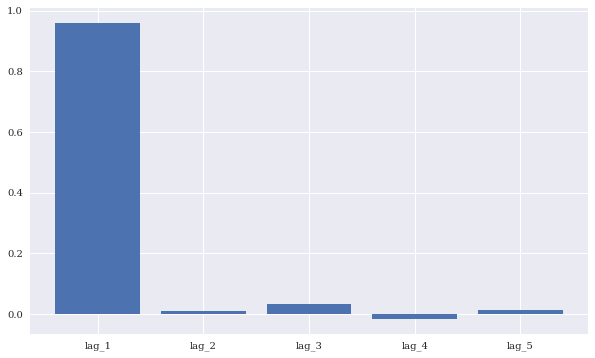

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg);
# plt.savefig('../../images/ch15/strat_plot_04.png');

In [43]:
data['Prediction'] = np.dot(data[cols], reg)

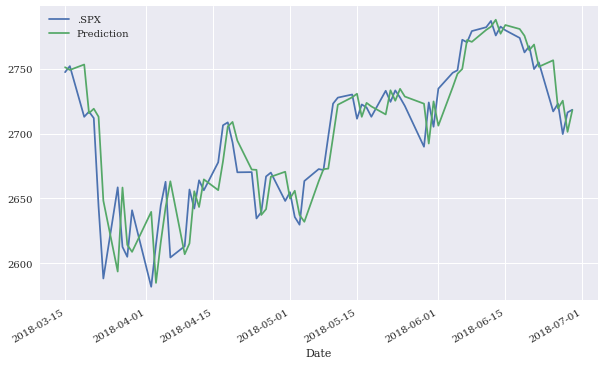

In [44]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_05.png');
# 因为系数中前一天基本就是0.96，所以绘制出来的图基本就像把前一天的值延迟一天而已

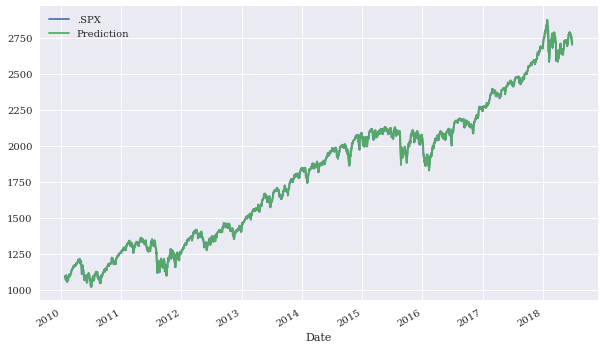

In [45]:
data[[symbol, 'Prediction']].plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_05.png');